## Import all essential libraries required for data preprocessing, modeling, and interpretability in this experiment

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

## Import and display the dataset

In [2]:
df = pd.read_csv("breast_cancer.csv")

In [3]:
print("Initial shape:", df.shape)

Initial shape: (4024, 16)


## Drop Rows with Missing Target and Create New Binary Target (5-Year Survival)

In [4]:
df.dropna(subset=['Survival Months'], inplace=True)

df['Survival_5yr'] = np.where(df['Survival Months'] >= 60, 1, 0)
df.drop(columns=['Survival Months'], inplace=True)

## Drop Unnamed or Irrelevant Columns

In [5]:
df = df.dropna(axis=1, how='all')  
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  
df.columns = df.columns.str.strip()  

## Separate features and target

In [6]:
X = df.drop('Survival_5yr', axis=1)
y = df['Survival_5yr']

## Convert categorical columns into numerical format using one-hot encoding and Fill missing values with the column mean using a simple imputer and Split the data into training and testing sets with stratification on the target

In [7]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
if categorical_cols:
    print(f"Encoding categorical columns: {categorical_cols}")
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

if X.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Encoding categorical columns: ['Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']


## Standardize features by removing the mean and scaling to unit variance using `StandardScaler`

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train a Support Vector Machine (SVM) classifier with an RBF kernel on the scaled training data

In [9]:
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Predict test data with the SVM model, calculate accuracy, and display the classification report and Visualize the confusion matrix for the SVM predictions using a heatmap



SVM Accuracy: 0.7677

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.34      0.47       241
           1       0.77      0.95      0.85       564

    accuracy                           0.77       805
   macro avg       0.76      0.65      0.66       805
weighted avg       0.76      0.77      0.74       805



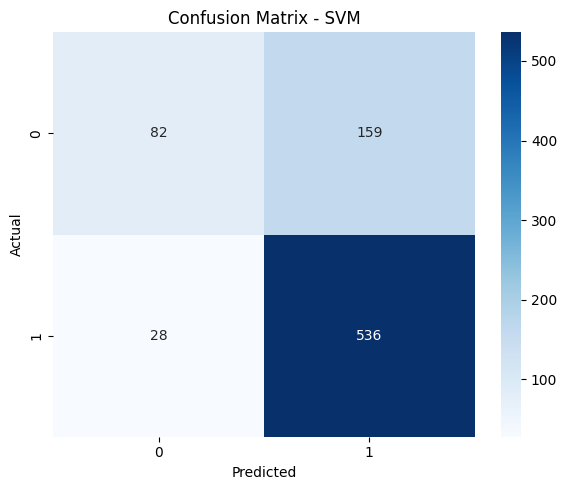

In [10]:
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nSVM Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.show()

## Feature importance using Random Forest 

In [11]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
top10_idx = np.argsort(importances)[-10:]
top5_idx = np.argsort(importances)[-5:]

top10_features = X.columns[top10_idx]
top5_features = X.columns[top5_idx]

print("\nTop 10 features:", top10_features.tolist())
print("Top 5 features:", top5_features.tolist())


Top 10 features: ['Race_White', 'Grade_Well differentiated; Grade I', 'Progesterone Status_Positive', 'Marital Status_Married (including common law)', 'Grade_Poorly differentiated; Grade III', 'Reginol Node Positive', 'Status_Dead', 'Tumor Size', 'Regional Node Examined', 'Age']
Top 5 features: ['Reginol Node Positive', 'Status_Dead', 'Tumor Size', 'Regional Node Examined', 'Age']


## Scale and Train SVM on Top 10 Features 

In [12]:
scaler_10 = StandardScaler()
X_train_top10 = scaler_10.fit_transform(X_train[top10_features])
X_test_top10 = scaler_10.transform(X_test[top10_features])

svm_top10 = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_top10.fit(X_train_top10, y_train)
y_pred_10 = svm_top10.predict(X_test_top10)

## Print accuracy, classification report, list the top 10 features, and display the confusion matrix heatmap


--- SVM on Top 10 Features ---
Accuracy: 0.7689
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       241
           1       0.77      0.95      0.85       564

    accuracy                           0.77       805
   macro avg       0.75      0.65      0.67       805
weighted avg       0.76      0.77      0.74       805

Top 10 features used: ['Race_White', 'Grade_Well differentiated; Grade I', 'Progesterone Status_Positive', 'Marital Status_Married (including common law)', 'Grade_Poorly differentiated; Grade III', 'Reginol Node Positive', 'Status_Dead', 'Tumor Size', 'Regional Node Examined', 'Age']


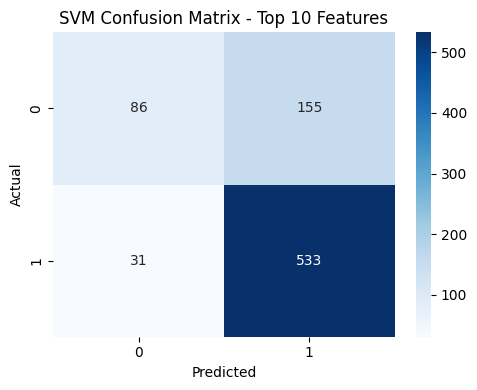

In [13]:
print("\n--- SVM on Top 10 Features ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_10):.4f}")
print(classification_report(y_test, y_pred_10))
print("Top 10 features used:", list(top10_features))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_10), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix - Top 10 Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Scale and Train SVM on Top 5 Features

In [14]:
scaler_5 = StandardScaler()
X_train_top5 = scaler_5.fit_transform(X_train[top5_features])
X_test_top5 = scaler_5.transform(X_test[top5_features])

svm_top5 = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_top5.fit(X_train_top5, y_train)
y_pred_5 = svm_top5.predict(X_test_top5)

## Print accuracy, classification report, list the top 5 features, and display the confusion matrix heatmap


--- SVM on Top 5 Features ---
Accuracy: 0.7702
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       241
           1       0.78      0.95      0.85       564

    accuracy                           0.77       805
   macro avg       0.76      0.65      0.67       805
weighted avg       0.76      0.77      0.74       805

Top 5 features used: ['Reginol Node Positive', 'Status_Dead', 'Tumor Size', 'Regional Node Examined', 'Age']


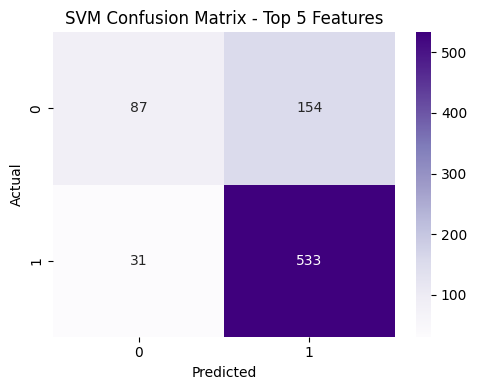

In [15]:
print("\n--- SVM on Top 5 Features ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_5):.4f}")
print(classification_report(y_test, y_pred_5))
print("Top 5 features used:", list(top5_features))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_5), annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix - Top 5 Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Predict probabilities for ROC 

In [16]:
y_prob_full = svm.predict_proba(X_test_scaled)[:, 1]
y_prob_top10 = svm_top10.predict_proba(X_test_top10)[:, 1]
y_prob_top5 = svm_top5.predict_proba(X_test_top5)[:, 1]

## Compute ROC Curve and AUC Scores

In [17]:
fpr_full, tpr_full, _ = roc_curve(y_test, y_prob_full)
auc_full = roc_auc_score(y_test, y_prob_full)

fpr_10, tpr_10, _ = roc_curve(y_test, y_prob_top10)
auc_10 = roc_auc_score(y_test, y_prob_top10)

fpr_5, tpr_5, _ = roc_curve(y_test, y_prob_top5)
auc_5 = roc_auc_score(y_test, y_prob_top5)

## Plot ROC Curves for SVM Models

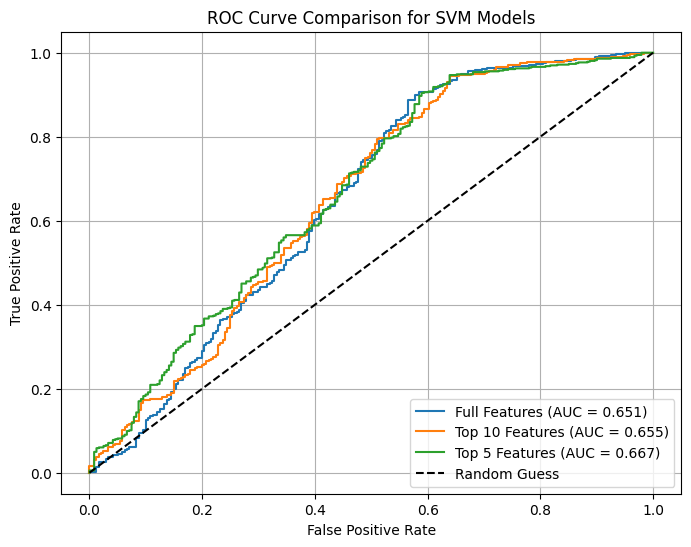

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f'Full Features (AUC = {auc_full:.3f})')
plt.plot(fpr_10, tpr_10, label=f'Top 10 Features (AUC = {auc_10:.3f})')
plt.plot(fpr_5, tpr_5, label=f'Top 5 Features (AUC = {auc_5:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for SVM Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Parameter grid for tuning

In [19]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

## Function tune and evaluate 

In [20]:
def tune_and_evaluate(X_train_scaled, X_test_scaled, model_name):
    print(f"\n--- Hyperparameter Tuning and Evaluation: {model_name} ---")
    svm_model = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=svm_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)
    best_svm = grid_search.best_estimator_
    print("Best params:", grid_search.best_params_)
    print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

    y_pred = best_svm.predict(X_test_scaled)
    y_prob = best_svm.predict_proba(X_test_scaled)[:, 1]

    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    return fpr, tpr, auc, model_name

## Tune and Evaluate on All Features


--- Hyperparameter Tuning and Evaluation: All Features ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV ROC-AUC: 0.6597
Test Accuracy: 0.7714
              precision    recall  f1-score   support

           0       0.75      0.35      0.48       241
           1       0.77      0.95      0.85       564

    accuracy                           0.77       805
   macro avg       0.76      0.65      0.67       805
weighted avg       0.77      0.77      0.74       805



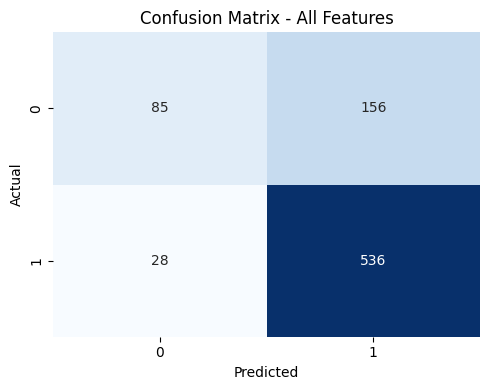

In [21]:
fpr_full, tpr_full, auc_full, name_full = tune_and_evaluate(X_train_scaled, X_test_scaled, "All Features")

## Tune and Evaluate on Top 10 Features (Scaled)


--- Hyperparameter Tuning and Evaluation: Top 10 Features ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV ROC-AUC: 0.6712
Test Accuracy: 0.7702
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       241
           1       0.78      0.95      0.85       564

    accuracy                           0.77       805
   macro avg       0.76      0.65      0.67       805
weighted avg       0.76      0.77      0.74       805



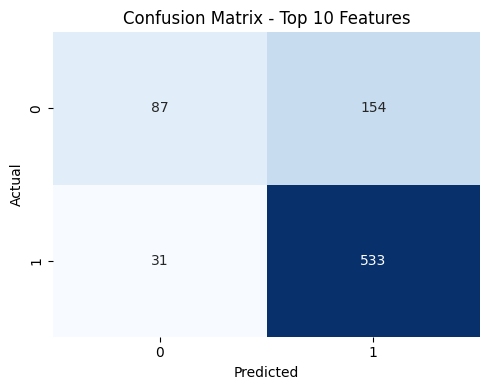

In [22]:
scaler_10 = StandardScaler()
X_train_top10 = scaler_10.fit_transform(X_train[top10_features])
X_test_top10 = scaler_10.transform(X_test[top10_features])
fpr_10, tpr_10, auc_10, name_10 = tune_and_evaluate(X_train_top10, X_test_top10, "Top 10 Features")

## Tune and evaluate on top 5 features (scaled)


--- Hyperparameter Tuning and Evaluation: Top 5 Features ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best CV ROC-AUC: 0.6677
Test Accuracy: 0.7329
              precision    recall  f1-score   support

           0       0.68      0.21      0.32       241
           1       0.74      0.96      0.83       564

    accuracy                           0.73       805
   macro avg       0.71      0.58      0.58       805
weighted avg       0.72      0.73      0.68       805



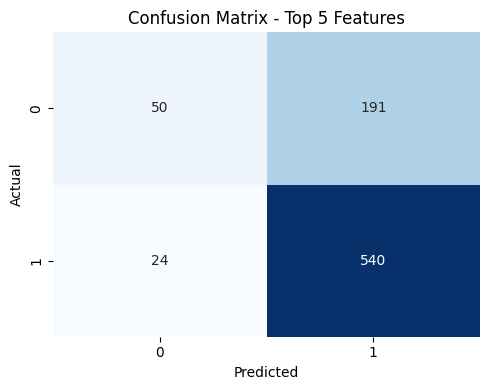

In [23]:
scaler_5 = StandardScaler()
X_train_top5 = scaler_5.fit_transform(X_train[top5_features])
X_test_top5 = scaler_5.transform(X_test[top5_features])
fpr_5, tpr_5, auc_5, name_5 = tune_and_evaluate(X_train_top5, X_test_top5, "Top 5 Features")

## Plot All ROC Curves Together

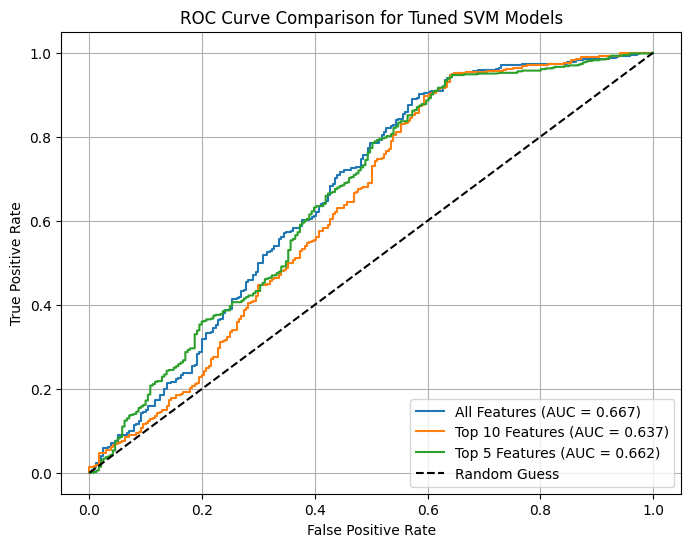

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f'{name_full} (AUC = {auc_full:.3f})')
plt.plot(fpr_10, tpr_10, label=f'{name_10} (AUC = {auc_10:.3f})')
plt.plot(fpr_5, tpr_5, label=f'{name_5} (AUC = {auc_5:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Tuned SVM Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Define the parameter grid

In [25]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1]
}


## Run GridSearchCV for all three feature sets

In [26]:
grid_all = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_all.fit(X_train_scaled, y_train)

grid_10 = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_10.fit(X_train_top10, y_train)

grid_5 = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_5.fit(X_train_top5, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,SVC(probabili...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


## Plot Cross-Validation ROC-AUC Scores

C:\Users\yeman\AppData\Local\Temp\ipykernel_36564\1052266102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


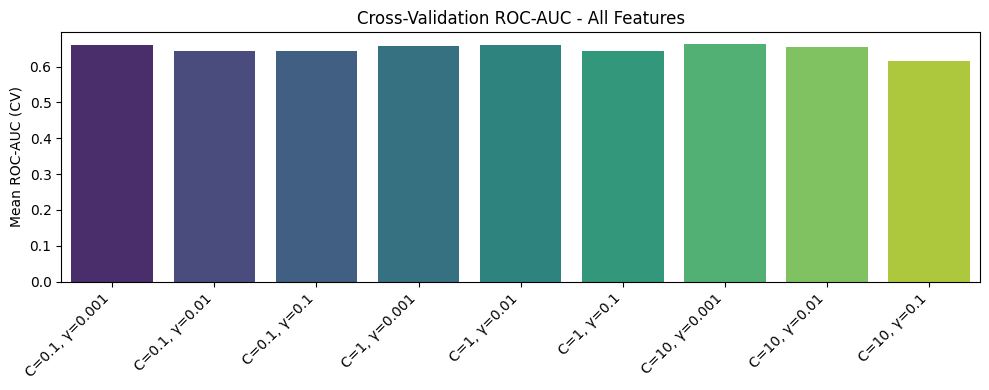

C:\Users\yeman\AppData\Local\Temp\ipykernel_36564\1052266102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


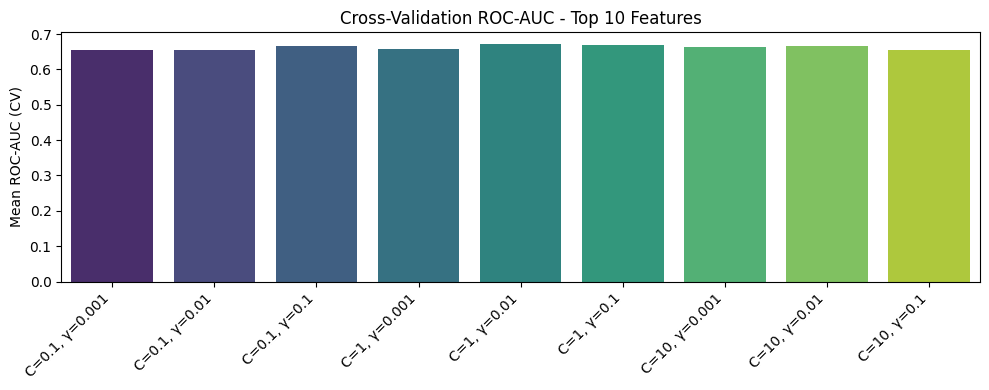

C:\Users\yeman\AppData\Local\Temp\ipykernel_36564\1052266102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


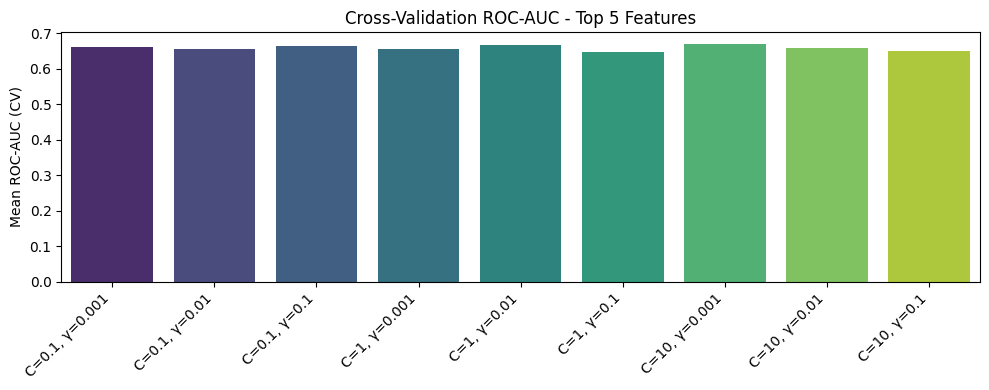

In [27]:
def plot_cv_scores(grid, title):
    scores = grid.cv_results_['mean_test_score']
    params = grid.cv_results_['params']
    labels = [f"C={p['C']}, γ={p['gamma']}" for p in params]

    plt.figure(figsize=(10, 4))
    sns.barplot(x=labels, y=scores, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Mean ROC-AUC (CV)")
    plt.title(f"Cross-Validation ROC-AUC - {title}")
    plt.tight_layout()
    plt.show()

plot_cv_scores(grid_all, "All Features")
plot_cv_scores(grid_10, "Top 10 Features")
plot_cv_scores(grid_5, "Top 5 Features")

## Print Best Parameters and Score

In [28]:
print("Best Params - All:", grid_all.best_params_, "| AUC:", grid_all.best_score_)
print("Best Params - Top 10:", grid_10.best_params_, "| AUC:", grid_10.best_score_)
print("Best Params - Top 5:", grid_5.best_params_, "| AUC:", grid_5.best_score_)

Best Params - All: {'C': 10, 'gamma': 0.001} | AUC: 0.662706913803868
Best Params - Top 10: {'C': 1, 'gamma': 0.01} | AUC: 0.6712475795305897
Best Params - Top 5: {'C': 10, 'gamma': 0.001} | AUC: 0.6685627173827251
